In [1]:
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.svm import *
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.cluster import *
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn.discriminant_analysis import *
from sklearn.ensemble import *
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna
import re
from time import time

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
X = train.drop(columns='label', axis=1)
y = train['label']

X_train,X_val,y_train,y_val=train_test_split(X,y,shuffle=True,test_size=0.3)

X_test = test.drop(columns='id', axis=1)

pca = PCA(240).fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [4]:
X_train.shape

(42000, 784)

In [4]:
def validate(model, X_train=X_train, X_val=X_val):
    start = time()
    model.fit(X_train, y_train)
    stop = time()
    print('training time:', stop-start)

    y_pred = model.predict(X_val)
    print(accuracy_score(y_pred, y_val))
    print(classification_report(y_pred, y_val))
    return model

In [5]:
random_state = 42

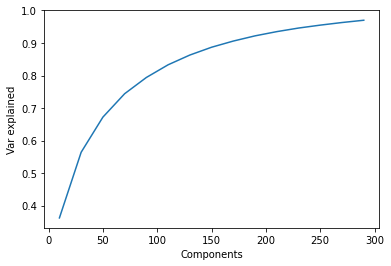

In [7]:
pca_var = pd.DataFrame(columns=['Components', 'Var explained'])

for i in np.arange(10, 300, 20):
    pca=PCA(n_components=i).fit(X)
    sum_var = pca.explained_variance_ratio_.sum()
    pca_var=pca_var.append({'Components':i, 'Var explained':round(sum_var, 3)}, ignore_index=True)

sns.lineplot(data=pca_var, x='Components', y='Var explained');

# RF

In [10]:
clf = RandomForestClassifier(n_jobs=-1)
validate(clf)

training time: 2.7805261611938477
0.9784444444444444
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1756
           1       0.99      0.97      0.98      1822
           2       0.99      1.00      0.99      1767
           3       0.97      0.96      0.97      1860
           4       0.99      0.98      0.98      1832
           5       0.99      0.98      0.98      1826
           6       0.97      0.96      0.97      1844
           7       0.96      0.97      0.96      1757
           8       0.99      0.99      0.99      1807
           9       0.97      0.99      0.98      1729

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



RandomForestClassifier(n_jobs=-1)

In [85]:
def objective(trial):    
    max_depth = trial.suggest_int('max_depth', 2, 100)
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_features= trial.suggest_int('max_features', 5, 784)
        
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth = max_depth,
                                   max_features = max_features,
                                   n_jobs=-1
                                  )
                           
    model.fit(X_train, y_train)
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=3, n_jobs=-1).mean()
    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2021-08-01 16:38:57,277] A new study created in memory with name: no-name-b0c595ba-f632-4a59-a22c-249bcd0d22d1
[I 2021-08-01 16:42:06,957] Trial 0 finished with value: 0.9630476190476189 and parameters: {'max_depth': 64, 'n_estimators': 128, 'max_features': 661}. Best is trial 0 with value: 0.9630476190476189.
[I 2021-08-01 16:42:51,680] Trial 1 finished with value: 0.9748095238095238 and parameters: {'max_depth': 75, 'n_estimators': 163, 'max_features': 113}. Best is trial 1 with value: 0.9748095238095238.
[I 2021-08-01 16:48:04,358] Trial 2 finished with value: 0.9669761904761905 and parameters: {'max_depth': 91, 'n_estimators': 272, 'max_features': 555}. Best is trial 1 with value: 0.9748095238095238.
[I 2021-08-01 16:48:11,709] Trial 3 finished with value: 0.9752380952380952 and parameters: {'max_depth': 57, 'n_estimators': 204, 'max_features': 9}. Best is trial 3 with value: 0.9752380952380952.
[I 2021-08-01 16:52:02,477] Trial 4 finished with value: 0.9539285714285715 and para

In [86]:
params = {'max_depth': 51, 
          'n_estimators': 167, 
          'max_features': 32}


clf_tuned = RandomForestClassifier(**params)
validate(clf_tuned)

training time: 36.67931604385376
0.9786666666666667
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1763
           1       0.99      0.97      0.98      1820
           2       0.99      1.00      0.99      1763
           3       0.97      0.96      0.97      1871
           4       0.98      0.98      0.98      1825
           5       0.98      0.98      0.98      1826
           6       0.97      0.96      0.97      1847
           7       0.96      0.97      0.97      1755
           8       0.99      1.00      0.99      1804
           9       0.97      0.99      0.98      1726

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



RandomForestClassifier(max_depth=51, max_features=32, n_estimators=167)

In [12]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
validate(clf)

training time: 12.731566190719604
0.9788333333333333
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1756
           1       0.99      0.97      0.98      1824
           2       0.99      1.00      0.99      1765
           3       0.97      0.96      0.97      1866
           4       0.99      0.98      0.98      1833
           5       0.99      0.98      0.99      1825
           6       0.97      0.96      0.96      1850
           7       0.95      0.97      0.96      1746
           8       0.99      1.00      0.99      1805
           9       0.97      0.99      0.98      1730

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



RandomForestClassifier(n_estimators=500, n_jobs=-1)

# PCA

In [13]:
clf_pca = RandomForestClassifier()
validate(clf_pca, X_train_pca, X_val_pca)

training time: 58.52517771720886
0.9613888888888888
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1741
           1       0.99      0.95      0.97      1860
           2       0.99      0.99      0.99      1768
           3       0.95      0.95      0.95      1850
           4       0.97      0.96      0.96      1831
           5       0.98      0.97      0.97      1829
           6       0.95      0.94      0.94      1850
           7       0.92      0.94      0.93      1742
           8       0.98      0.98      0.98      1803
           9       0.96      0.98      0.97      1726

    accuracy                           0.96     18000
   macro avg       0.96      0.96      0.96     18000
weighted avg       0.96      0.96      0.96     18000



RandomForestClassifier()

In [14]:
params = {'max_depth': 17, 
          'n_estimators': 213, 
          'criterion': 'entropy', 
          'min_samples_split': 2, 
          'min_samples_leaf': 2, 
          'max_features': 157}
clf_pca_tuned = RandomForestClassifier(**params)
validate(clf_pca_tuned, X_train_pca, X_val_pca)

training time: 2477.470538854599
0.9591111111111111
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1705
           1       0.98      0.94      0.96      1859
           2       0.99      0.99      0.99      1768
           3       0.96      0.93      0.94      1887
           4       0.97      0.97      0.97      1814
           5       0.97      0.97      0.97      1826
           6       0.96      0.94      0.95      1866
           7       0.93      0.95      0.94      1751
           8       0.97      0.97      0.97      1810
           9       0.95      0.98      0.96      1714

    accuracy                           0.96     18000
   macro avg       0.96      0.96      0.96     18000
weighted avg       0.96      0.96      0.96     18000



RandomForestClassifier(criterion='entropy', max_depth=17, max_features=157,
                       min_samples_leaf=2, n_estimators=213)

# KMeans

In [17]:
clf_k=KMeans(10)
validate(clf_k)

training time: 10.513549089431763
0.10111111111111111
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       925
           1       0.00      0.00      0.00      2169
           2       0.00      0.00      0.00      1501
           3       0.00      0.00      0.00      1855
           4       0.97      0.74      0.84      2380
           5       0.01      0.01      0.01      3146
           6       0.01      0.01      0.01      1775
           7       0.00      0.00      0.00      1655
           8       0.00      0.00      0.00       765
           9       0.01      0.01      0.01      1829

    accuracy                           0.10     18000
   macro avg       0.10      0.08      0.09     18000
weighted avg       0.13      0.10      0.11     18000



KMeans(n_clusters=10)

In [22]:
clf_k.fit(X_train, y_train)

KMeans(n_clusters=10)

In [9]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels.iloc[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [63]:
cluster_labels = infer_cluster_labels(clf_k, y_train)
X_clusters = clf_k.predict(X_val)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:10])
print(y_train[:10])

[3 4 6 1 0 2 3 3 5 8]
17724    4
40169    9
1961     1
33074    4
40240    0
19655    5
22655    5
50714    4
20295    5
17690    0
Name: label, dtype: int64


In [65]:
accuracy_score(predicted_labels, y_val)

0.7416666666666667

In [16]:
clf_k=KMeans(81).fit(X_train, y_train)
cluster_labels = infer_cluster_labels(clf_k, y_train)
X_clusters = clf_k.predict(X_val)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
accuracy_score(predicted_labels, y_val)

0.9200555555555555

In [11]:
scores=pd.DataFrame(columns=['n_clusters', 'accuracy'])
for i in range(20, 100):
    clf_k=KMeans(i, n_jobs=-1).fit(X_train, y_train)
    cluster_labels = infer_cluster_labels(clf_k, y_train)
    X_clusters = clf_k.predict(X_val)
    predicted_labels = infer_data_labels(X_clusters, cluster_labels)
    score = accuracy_score(predicted_labels, y_val)
    scores=scores.append({'n_clusters':i, 'accuracy':round(score, 3)}, ignore_index=True)

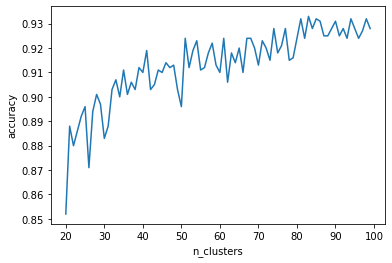

In [13]:
sns.lineplot(data=scores, x='n_clusters', y='accuracy');

In [15]:
scores.loc[scores['accuracy'] > 0.93]

,n_clusters,accuracy
61,81.00,0.93
63,83.00,0.93
65,85.00,0.93
66,86.00,0.93
70,90.00,0.93
74,94.00,0.93
78,98.00,0.93


In [89]:
clf_k=KMeans(27).fit(X_train_pca, y_train)
cluster_labels = infer_cluster_labels(clf_k, y_train)
X_clusters = clf_k.predict(X_val_pca)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
accuracy_score(predicted_labels, y_val)

0.8758888888888889